In [1]:
import numpy as np
import ellipse as el
from uncertainties import ufloat,umath
import matplotlib.pyplot as plt

# Estimation of errors in ellipse fitting

The ellipse fitting under [`lsq-ellipse`](https://github.com/bdhammel/least-squares-ellipse-fitting) is done based on the polynomial fitting i.e.

\begin{equation}
    ax^2 + bxy + cy^2 + dx + ey + f = 0
\end{equation}

with the constraint $b^2 < 4ac$. 

In [2]:
def generate_ellipse(a,b,center=(0,0),n=100,phi=0,weight=0.2):
    t = np.linspace(0,2*np.pi,n)[:-1]
    x = a*np.cos(t)*np.cos(phi) - b*np.sin(t)*np.sin(phi) + center[0]
    y = a*np.cos(t)*np.sin(phi) + b*np.sin(t)*np.cos(phi) + center[1]
    x += np.random.randn(len(t))*weight
    y += np.random.randn(len(t))*weight
    return x,y

In [3]:
# generating ellipse using random parameters
x,y = generate_ellipse(np.random.uniform(1,5),np.random.uniform(1,5),
                        (np.random.uniform(-5,5),np.random.uniform(-5,5)),
                        100,np.random.uniform(0,np.pi))

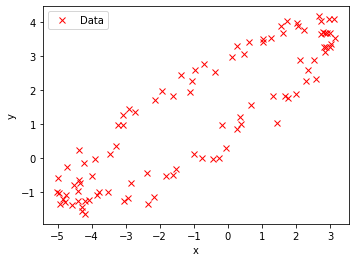

In [4]:
# plot of raw data
fig,ax = plt.subplots()
ax.plot(x,y,'xr',label='Data')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
plt.show()

In [5]:
# lsq-ellipse best fit coefficients
fit = el.LsqEllipse().fit(np.vstack([x,y]).T)
params = fit.coefficients
params

(-0.2952202972824165,
 0.7267823448941844,
 -0.6201873904092152,
 -1.4144803200719385,
 2.17112554571887,
 -0.81591017289733)

To estimate the error, we start by defining the auxilary data set, $z_{ij}$

\begin{equation}
    z_{ij} = \begin{pmatrix}x_j^2 \\ x_jy_j \\ y_j^2 \\ x_j \\ y_j \\ \alpha_j\end{pmatrix}
\end{equation}

where $\alpha_j = 1$. We then obtain the goodness of fit of the data using the chi-squared and equating it to the degrees of freedom i.e. $m-6$, giving us

\begin{equation}
    \chi^2 = \sum_{j=1}^m \frac{(\sum_{i=1}^6a_iz_{ij}-1)^2}{\sigma_j^2} = m - 6
\end{equation}

where $\sigma_j$ is the uncertainty for data point $x_j,y_j$, and the best fit parameters $\hat{a}_i = [a, b, c, d, e, f]$ minimizes the distribution. After derivation based on McDonald, 2014 ([Google Scholar](https://scholar.google.com/citations?view_op=view_citation&hl=en&user=W9iFjWQAAAAJ&cstart=400&pagesize=100&citation_for_view=W9iFjWQAAAAJ:SgM-ki2adj0C)), we obtain the uncertainties for the parameters.

\begin{equation}
    \sigma_{\hat{a}_i} = \sqrt{\frac{\sum_{j=1}^m\left(\sum_{k=1}^6 \hat{a}_kz_{kj} - 1\right)^2}{(m-6)\sum_{j=1}^m z_{ij}^2}}
\end{equation}

To evaluate the summation terms, we utlize array multiplications. The first summation terms can be obtained using

\begin{align*}
    \sum_{k=1}^6 \hat{a}_kz_{kj} &= \hat{a} \cdot z = z^T \cdot \hat{a}^T \\
    & = \begin{pmatrix}
        x_1^2 & x_1y_1 & y_1^2 & x_1 & y_1 & 1 \\
        x_2^2 & x_2y_2 & y_2^2 & x_2 & y_2 & 1 \\
        x_3^2 & x_3y_3 & y_3^2 & x_3 & y_3 & 1 \\
        \vdots & \vdots & \vdots & \vdots & \vdots & \vdots
    \end{pmatrix}\begin{pmatrix}
        a \\ b \\ c \\ d \\ e \\ f
    \end{pmatrix} \\
    &= \begin{pmatrix}
        ax_1^2 + bx_1y_1 + cy_1^2 + dx_1 + ey_1 + f \\
        ax_2^2 + bx_2y_2 + cy_2^2 + dx_2 + ey_2 + f \\
        ax_3^2 + bx_3y_3 + cy_3^2 + dx_3 + ey_3 + f \\
        \vdots
    \end{pmatrix}
\end{align*}

Note: The transpose of the matrices are used here for cleaner visual representation, but the code implements them directly.

In [6]:
# calculating uncertainty
def unc_calc(x,y,A):
    m = len(x)
    z = np.array([x**2,x*y,y**2,x,y,np.ones(m)])
    numerator = np.sum(((A @ z)-1)**2)
    denominator = (m-6)*np.sum(z**2,axis=1)
    unc = np.sqrt(numerator/denominator)
    return tuple([ufloat(i,j) for i,j in zip(A,unc)])

In [7]:
params = unc_calc(x,y,params)
params

(-0.2952202972824165+/-0.009644870522628085,
 0.7267823448941844+/-0.0196414099701486,
 -0.6201873904092152+/-0.014472149648823672,
 -1.4144803200719385+/-0.03738149018416395,
 2.17112554571887+/-0.047875819453121665,
 -0.81591017289733+/-0.10880487042846906)

However, these are polynomial parameters and has to be converted into the usual ellipse parameters; center, semi major and minor axes, and rotation angle, so that the result has a physical significance. This also means that the errors has to be propagated, and to do so we utilize the [`uncertainties`](https://github.com/lebigot/uncertainties) package.

In [8]:
# converting coefficients to usual ellipse parameters with uncertainties
def convert_w_unc(coeff):
    a,b,c,d,f,g = coeff
    b /= 2
    d /= 2
    f /= 2
    x0 = (c*d - b*f) / (b**2. - a*c)
    y0 = (a*f - b*d) / (b**2. - a*c)
    center = (x0, y0)
    numerator = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    denominator1 = (b*b-a*c)*((c-a)*umath.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    denominator2 = (b*b-a*c)*((a-c)*umath.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    width = umath.sqrt(numerator/denominator1)
    height = umath.sqrt(numerator/denominator2)    
    phi = .5*umath.atan((2*b)/(a-c))
    return center, width, height, phi

In [9]:
center, a, b, phi = convert_w_unc(params)
center, a, b, phi

((-0.8647839231656076+/-0.33920281160010013,
  1.2436691571525842+/-0.22951652811151615),
 4.383069724478465+/-0.5030445026967668,
 1.157105756182277+/-0.06950233897881765,
 0.5751653104282936+/-0.011170469235333796)

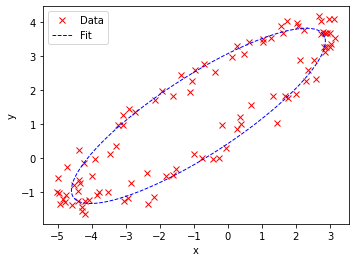

In [10]:
# plot of fit
t = np.linspace(0,2*np.pi,100)
xx = center[0].n+a.n*np.cos(t)*np.cos(phi.n)-b.n*np.sin(t)*np.sin(phi.n)
yy = center[1].n+a.n*np.cos(t)*np.sin(phi.n)+b.n*np.sin(t)*np.cos(phi.n)

fig,ax = plt.subplots()
ax.plot(x,y,'xr',label='Data')
ax.plot(xx,yy,'--b',lw=1,label='Fit')
ax.legend()
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_aspect('equal')
plt.show()

In [11]:
# covenience function
def fit(x,y):
    fit = el.LsqEllipse().fit(np.vstack([x,y]).T).coefficients
    m = len(x)
    z = np.array([x**2,x*y,y**2,x,y,np.ones(m)])
    numerator = np.sum(((fit @ z)-1)**2)
    denominator = (m-6)*np.sum(z**2,axis=1)
    unc = np.sqrt(numerator/denominator)
    a,b,c,d,f,g = [ufloat(i,j) for i,j in zip(fit,unc)]
    b /= 2
    d /= 2
    f /= 2
    x0 = (c*d - b*f) / (b**2. - a*c)
    y0 = (a*f - b*d) / (b**2. - a*c)
    center = (x0, y0)
    numerator = 2 * (a*f**2 + c*d**2 + g*b**2 - 2*b*d*f - a*c*g)
    denominator1 = (b*b-a*c)*((c-a)*umath.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    denominator2 = (b*b-a*c)*((a-c)*umath.sqrt(1+4*b*b/((a-c)*(a-c)))-(c+a))
    width = umath.sqrt(numerator/denominator1)
    height = umath.sqrt(numerator/denominator2)    
    phi = .5*umath.atan((2*b)/(a-c))
    # deals with the semi major and semi minor axes definitions
    if width > height:
        return center, width, height, phi
    else:
        return center, height, width, np.pi/2+phi

fit(x,y)

((-0.8647839231656076+/-0.33920281160010013,
  1.2436691571525842+/-0.22951652811151615),
 4.383069724478465+/-0.5030445026967668,
 1.157105756182277+/-0.06950233897881765,
 0.5751653104282936+/-0.011170469235333796)